In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import uproot
import random
from IPython.display import clear_output

Welcome to JupyROOT 6.28/04


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Define the autoencoder model
class Encoder(nn.Module):
    def __init__(self, input_size=13, hidden_size1=32, hidden_size2=16, z_dim=4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, z_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self, output_size=13, hidden_size1=16, hidden_size2=32, z_dim=4): #input output eşit olmalı:9
        super().__init__() 
        self.fc1 = nn.Linear(z_dim, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [6]:
enc = Encoder()
dec = Decoder()

In [7]:
enc.load_state_dict(torch.load("../saved_models/enc.pt"))
dec.load_state_dict(torch.load("../saved_models/dec.pt"))

<All keys matched successfully>

In [8]:
# Load the prepared data for performance evaluation
loaded_data = np.load('dataset.npz')
X_train = loaded_data['X_train']
X_test  = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test  = loaded_data['y_test']
X_non_prompt = loaded_data['X_non_prompt']
y_non_prompt = loaded_data['y_non_prompt']

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

X_non_prompt = torch.tensor(X_non_prompt, dtype=torch.float)

y_non_prompt = torch.tensor(y_non_prompt, dtype=torch.float)

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
non_prompt_dataset = TensorDataset(X_non_prompt, y_non_prompt)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
non_prompt_loader = DataLoader(dataset=non_prompt_dataset, batch_size=1, shuffle=True)

In [9]:
# Define the loss function
loss_fn = nn.MSELoss()

def evaluate_losses(enc, dec, loss_fn, dataloader):
    enc.eval()
    dec.eval()
    output = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.flatten(1)
            inputs = inputs.to(device)
            latents = enc(inputs)
            outputs = dec(latents)
            loss = loss_fn(outputs, inputs)
            output.append(loss.item())
    return(output)

In [10]:
train_loss = evaluate_losses(enc, dec, loss_fn, train_loader)
val_loss = evaluate_losses(enc, dec, loss_fn, train_loader)
non_prompt_loss = evaluate_losses(enc, dec, loss_fn, non_prompt_loader)

In [11]:
loaded_data = np.load('loss_data.npz')
train_loss = loaded_data['train_loss']
val_loss = loaded_data['val_loss']
non_prompt_loss = loaded_data['non_prompt_loss']

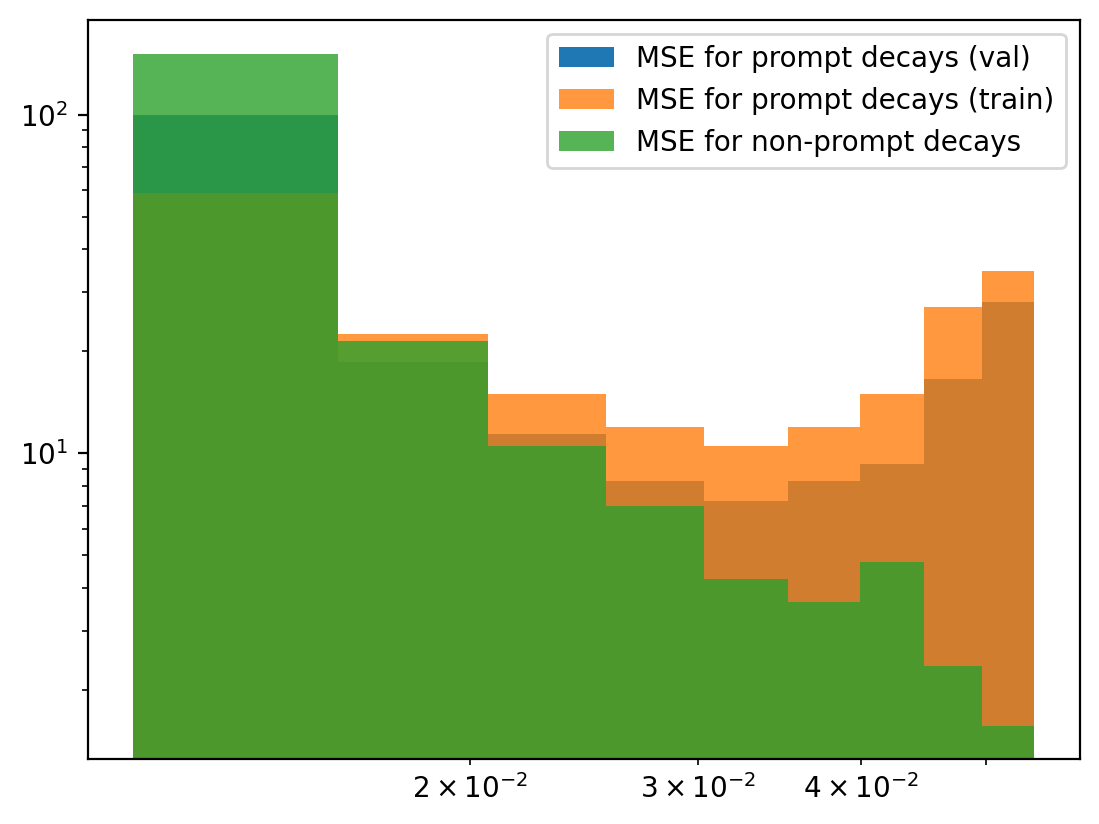

In [12]:
val_hist = plt.hist(val_loss, density=True, bins="auto", label = "MSE for prompt decays (val)")
train_hist = plt.hist(train_loss, density=True, bins=val_hist[1], alpha=0.8, label = "MSE for prompt decays (train)" )
non_prompt_hist = plt.hist(non_prompt_loss, density=True, bins=val_hist[1], alpha=0.8, label= "MSE for non-prompt decays")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right")

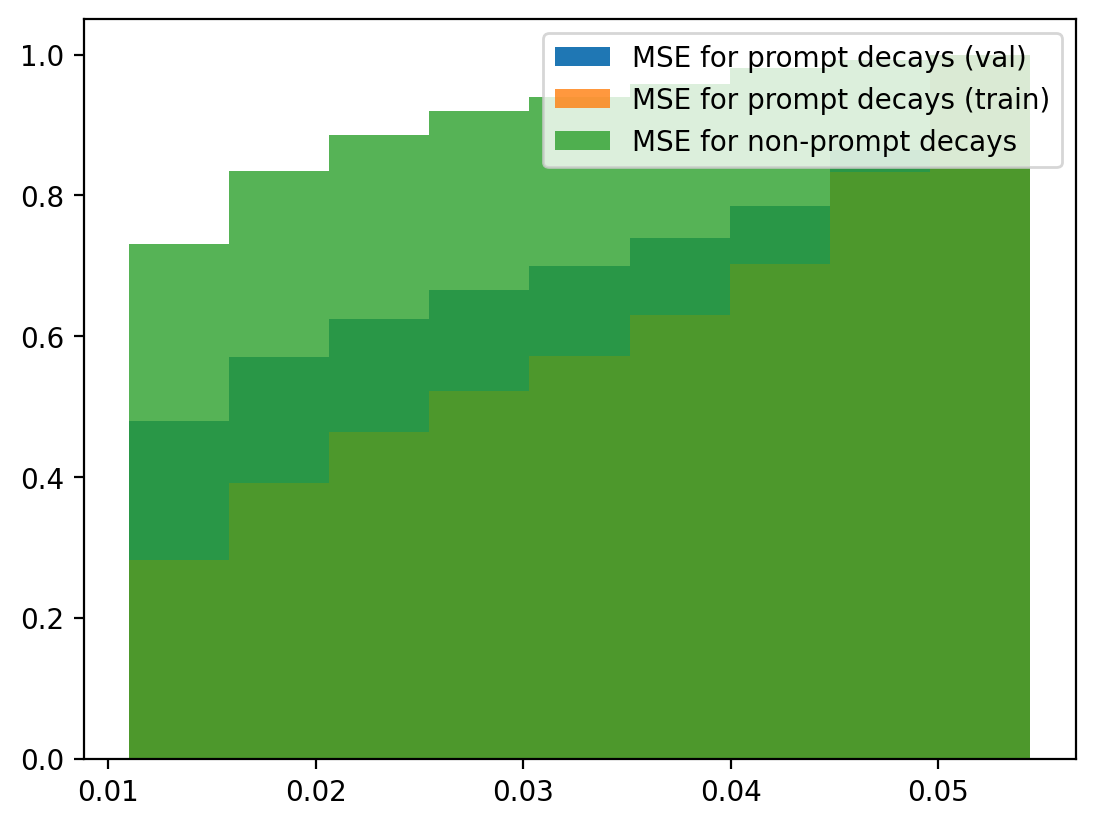

In [13]:
val_hist = plt.hist(val_loss, density=True, cumulative=True, bins="auto", label = "MSE for prompt decays (val)")
train_hist = plt.hist(train_loss, density=True,cumulative=True, bins=val_hist[1], alpha=0.8, label = "MSE for prompt decays (train)" )
non_prompt_hist = plt.hist(non_prompt_loss, density=True, cumulative=True,bins=val_hist[1], alpha=0.8, label= "MSE for non-prompt decays")
plt.legend(loc="upper right")

In [14]:
def get_lower_percentage(hist, threshold=0.1):
    idx = np.searchsorted(hist[1], threshold)-1
    return hist[0][idx]


In [18]:
threshold = 0.017

In [19]:
get_lower_percentage(val_hist, threshold) # true prompt ratio

0.57

In [20]:
1-get_lower_percentage(non_prompt_hist, threshold) # true non-prompt ratio

0.1648685610089652